In [1]:
%matplotlib inline
import sys
sys.path.append('../code')
from rnnmodel import *
from plotutils import *

In [2]:
"""
Parameters and settings used to generate TAP dynamics
"""

noise_seed = np.random.randint(10000)
np.random.seed(noise_seed)
torch.manual_seed(noise_seed)
print('noise_seed = %d' %(noise_seed))

model_type = 1 # 1: Ux + b, 0: Ux

# Ns = no. of latent variables, Nr = no. of neurons, Ny = no. of inputs
Ns, Nr, Ny = 25, 500, 25

# process and observation noise covariance matrices
q_process, q_obs = 0, 0
Q_process, Q_obs = q_process*np.eye(Ns), q_obs*np.eye(Nr)    

# filter used for smoothing the input signals
smoothing_filter = signal.hamming(5,sym=True) 
smoothing_filter = smoothing_filter/sum(smoothing_filter)

"""
ground truth TAP model parameters
"""
lam = np.array([0.25])  # low pass filtering constant for the TAP dynamics

G   = np.array([0,2,0,0,0,0,0,0,0,0,4,-4,0,-8,8,0,0,0]) # message passing parameters of the TAP equation

block_diagonalJ = 1
if block_diagonalJ:
    self_coupling_on, sparsity_J, gain_J, Jtype  = 1, 0, 3, 'nonferr'
    J = np.zeros([Ns,Ns])
    M = Ns//4
    J[0:M,0:M] = 1*Create_J(M, sparsity_J, 'ferr', self_coupling_on)
    J[M:2*M,M:2*M] = 1*Create_J(M, sparsity_J, 'antiferr', self_coupling_on)
    J[2*M:,2*M:] = gain_J*Create_J(Ns-2*M, 0.25, 'nonferr', self_coupling_on)
    del M
else:
    self_coupling_on, sparsity_J, gain_J, Jtype  = 1, 0.25, 3, 'nonferr' # interaction matrix settings
    J = gain_J*Create_J(Ns, sparsity_J, Jtype, self_coupling_on) # interaction matrix 

if model_type:
    gain_U = 1.5
    U   = gain_U*np.random.randn(Nr,Ns) # embedding matrix
else:
    gain_U = 3
    U   = gain_U*np.random.rand(Nr,Ns) # embedding matrix

if Ns <= Ny:
    V = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[2]
else:
    V = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[0]

# concatenate parameters
theta = np.concatenate([lam, G, JMatToVec(J), U.flatten('F'), V.flatten('F') ])

params = {'Ns':Ns,'Ny':Ny,'Nr':Nr,'Q_process':Q_process,'Q_obs':Q_obs,'nltype':'sigmoid','gain_y':25/np.sqrt(Ns),'smoothing_filter':smoothing_filter,'self_coupling_on':self_coupling_on,'sparsity_J':sparsity_J,'Jtype':Jtype  }

noise_seed = 1174


In [3]:
"""
Generate training and validation data
"""

B_train, B_val = 20000, 500      # No. of batches
T = 50                           # No. of time steps 
T_clip  = 20                     # No. of time steps to clip
T_low, T_high = 2, 5             # range of time periods for which input is held constant
yG_low, yG_high = 5, 50          # range of input gains

y_train, _, r_train = generate_TAPdynamics(theta, params, B_train, T+T_clip, T_low, T_high, yG_low, yG_high)

y_val, _, r_val = generate_TAPdynamics(theta, params, B_val, T+T_clip, T_low, T_high, yG_low, yG_high)

In [4]:
"""
Add baseline activity to the targets
"""

baseline = -np.min(r_train) if model_type else 0

r_train += baseline
r_val += baseline

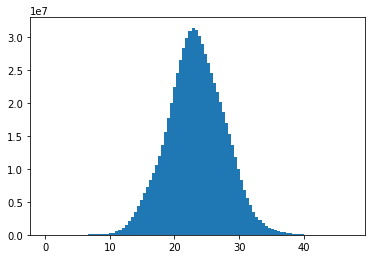

In [5]:
"""
Plot histogram of training data
"""
plt.hist(r_train.flatten(),100)
plt.show()

In [6]:
"""
Convert ground truth dynamics data to torch tensors
"""    

y_train = torch.tensor(y_train.transpose(0,2,1), dtype=torch.float32) # input signal
r_train = torch.tensor(r_train.transpose(0,2,1), dtype=torch.float32) # target neural activity

y_val = torch.tensor(y_val.transpose(0,2,1), dtype=torch.float32) # input signal
r_val = torch.tensor(r_val.transpose(0,2,1), dtype=torch.float32) # target neural activity


print('No. of batches x T x No. of neurons')
print('Training data:', r_train.shape, 'Validation data:', r_val.shape)

No. of batches x T x No. of neurons
Training data: torch.Size([20000, 70, 500]) Validation data: torch.Size([500, 70, 500])


In [7]:
"""
Create RNN module
"""

N_input, N_hidden, N_output = Ny, 2500, Nr

use_cuda = True

tapbrain = RNN(N_input, N_hidden, N_output, use_cuda)

loss_fn = nn.MSELoss()

if use_cuda and torch.cuda.is_available():
    tapbrain.cuda()

In [8]:
NIters = 50000  # No. of iterations for training the RNN
batch_size = 200  # batch size for training the RNN
epoch = B_train//batch_size

learningrate = 1e-5
optimizer = optim.Adam(tapbrain.parameters(), lr=learningrate, betas=(0.9, 0.999))

train_loss, val_loss = [], []

In [17]:
NIters = 10000
learningrate = 1e-6
optimizer = optim.Adam(tapbrain.parameters(), lr=learningrate, betas=(0.9, 0.999))

In [18]:
"""
Train the RNN
"""

t_st = time.time()
 
for iteration in range(NIters):
    
    # if iteration == NIters//2:
    #     optimizer = optim.Adam(tapbrain.parameters(), lr=learningrate/2, betas=(0.9, 0.999))

    # if iteration == 3*NIters//4:
    #     optimizer = optim.Adam(tapbrain.parameters(), lr=learningrate/4, betas=(0.9, 0.999))
    
    optimizer.zero_grad()
    
    batch_index = torch.randint(0, B_train,(batch_size,))
    rhat_train  = tapbrain(y_train[batch_index].cuda())[0]
    
    mse_train = loss_fn(r_train[batch_index,T_clip:].cuda(), rhat_train[:,T_clip:])
    
    mse_train.backward()  
    
    optimizer.step()
    
    if (iteration + 1) % epoch == 0:
        with torch.no_grad():
            rhat_val = tapbrain(y_val.cuda())[0]
            mse_val = loss_fn(r_val[:,T_clip:].cuda(), rhat_val[:,T_clip:])
            
        train_loss.append(mse_train.item())
        val_loss.append(mse_val.item())
        
    if (iteration + 1) % 5000 == 0:
        print('[%d] training loss: %.5f' %(iteration + 1, mse_train.item()))

print('Finished training')
t_en = time.time()
print('Time elapsed = %.2f mins' %((t_en - t_st)/60))

[5000] training loss: 0.07560
[10000] training loss: 0.07994
Finished training
Time elapsed = 46.80 mins


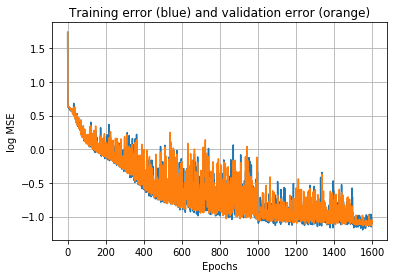

In [19]:
"""
Plot the training and validation MSE as a function of epochs
"""
plt.plot(np.log10(np.array(train_loss)))
plt.plot(np.log10(np.array(val_loss)))
plt.title('Training error (blue) and validation error (orange)')
plt.ylabel('log MSE')
plt.xlabel('Epochs')
plt.grid(True)
plt.show()

In [20]:
"""
Convert model to cpu and run the entire training and test data through the model
"""

tapbrain.cpu()
tapbrain.use_cuda = False

with torch.no_grad():
    rhat_val    = tapbrain(y_val)[0]


In [21]:
"""
Convert torch tensors to numpy
"""

del y_train, r_train

y_val    = y_val[:,T_clip:].data.numpy()
r_val    = r_val[:,T_clip:].data.numpy()
rhat_val = rhat_val[:,T_clip:].data.numpy()


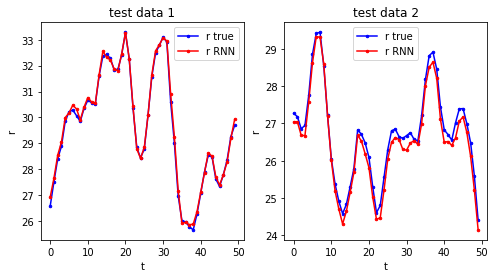

In [22]:
"""
Plot fits to test data
"""
fig, ax = plt.subplots(1,2,figsize=(8,4))

ax[0].plot(r_val[5,:,1],'b.-',markersize=5)
ax[0].plot(rhat_val[5,:,1],'r.-',markersize=5)
ax[0].set(xlabel='t', ylabel='r', title ='test data 1')
ax[0].legend(['r true', 'r RNN'])

ax[1].plot(r_val[2,:,0],'b.-',markersize=5)
ax[1].plot(rhat_val[2,:,0],'r.-',markersize=5)
ax[1].set(xlabel='t', ylabel='r', title ='test data 2')
ax[1].legend(['r true', 'r RNN'])

plt.show()

In [23]:
"""
Generate another test data set
"""

B_test = 5  # No. of batches
T_test = 1000 # No. of time steps 

y_test, _, r_test = generate_TAPdynamics(theta, params, B_test, T_test+T_clip, T_low, T_high, yG_low, yG_high)

r_test = r_test.transpose(0,2,1) + baseline
y_test = torch.tensor(y_test.transpose(0,2,1), dtype=torch.float32) 

print('No. of batches x T x No. of neurons')
print('Test data:', r_test.shape)

No. of batches x T x No. of neurons
Test data: (5, 1020, 500)


In [24]:
"""
Run model on test data
"""
with torch.no_grad():
    rhat_test = tapbrain(y_test)[0]

y_test    = y_test[:,T_clip:].data.numpy()
r_test    = r_test[:,T_clip:]
rhat_test = rhat_test[:,T_clip:].data.numpy()

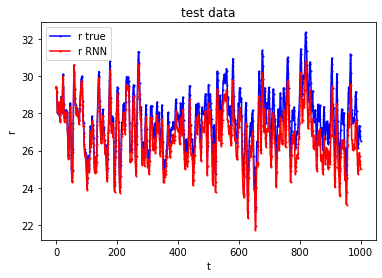

In [25]:
"""
Test data
"""
plt.plot(r_test[0,:,0],'b.-',markersize=2)
plt.plot(rhat_test[0,:,0],'r.-',markersize=2)
plt.xlabel('t')
plt.ylabel('r')
plt.title('test data')
plt.legend(['r true', 'r RNN'])
plt.show()

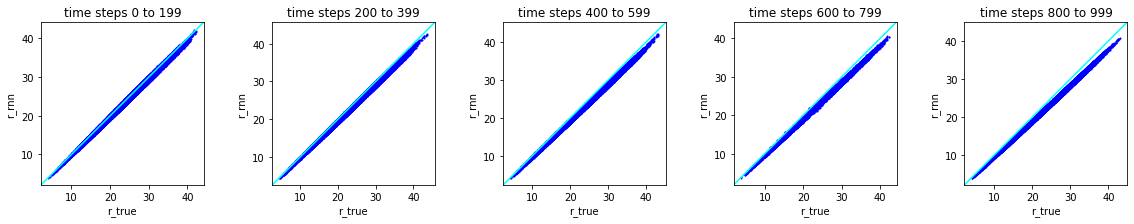

In [26]:
"""
Scatter plot for test data for every C time steps
"""
C = 200
N = T_test//C


fig, ax = plt.subplots(1,N,figsize=(4*N,3))
rmax = np.max(r_test)+2
for ni in range(N):
    ax[ni].plot(r_test[:,ni*C:(ni+1)*C].flatten(), rhat_test[:,ni*C:(ni+1)*C].flatten(),'b.',markersize=2)
    ax[ni].axis('square')
    ax[ni].plot([0,rmax],[0,rmax],color='cyan')
    ax[ni].set(xlabel='r_true', ylabel='r_rnn', title = 'time steps ' +str(ni*C)+ ' to ' + str(ni*C + C-1))

In [27]:
"""
Save trained brain and required variables
"""

brain_name = '../data/brains/' + 'Ns_'+ str(Ns) + '_noiseseed_' + str(noise_seed)
torch.save(tapbrain,brain_name + '.pt')

params['baseline'] = baseline
with open(brain_name + '_params.pkl', 'wb') as f:  
    pickle.dump([theta, params], f)
f.close()

In [28]:
brain_name

'../data/brains/Ns_25_noiseseed_1174'